Loaded data shape: (59, 61)
Prepared 1301 data points


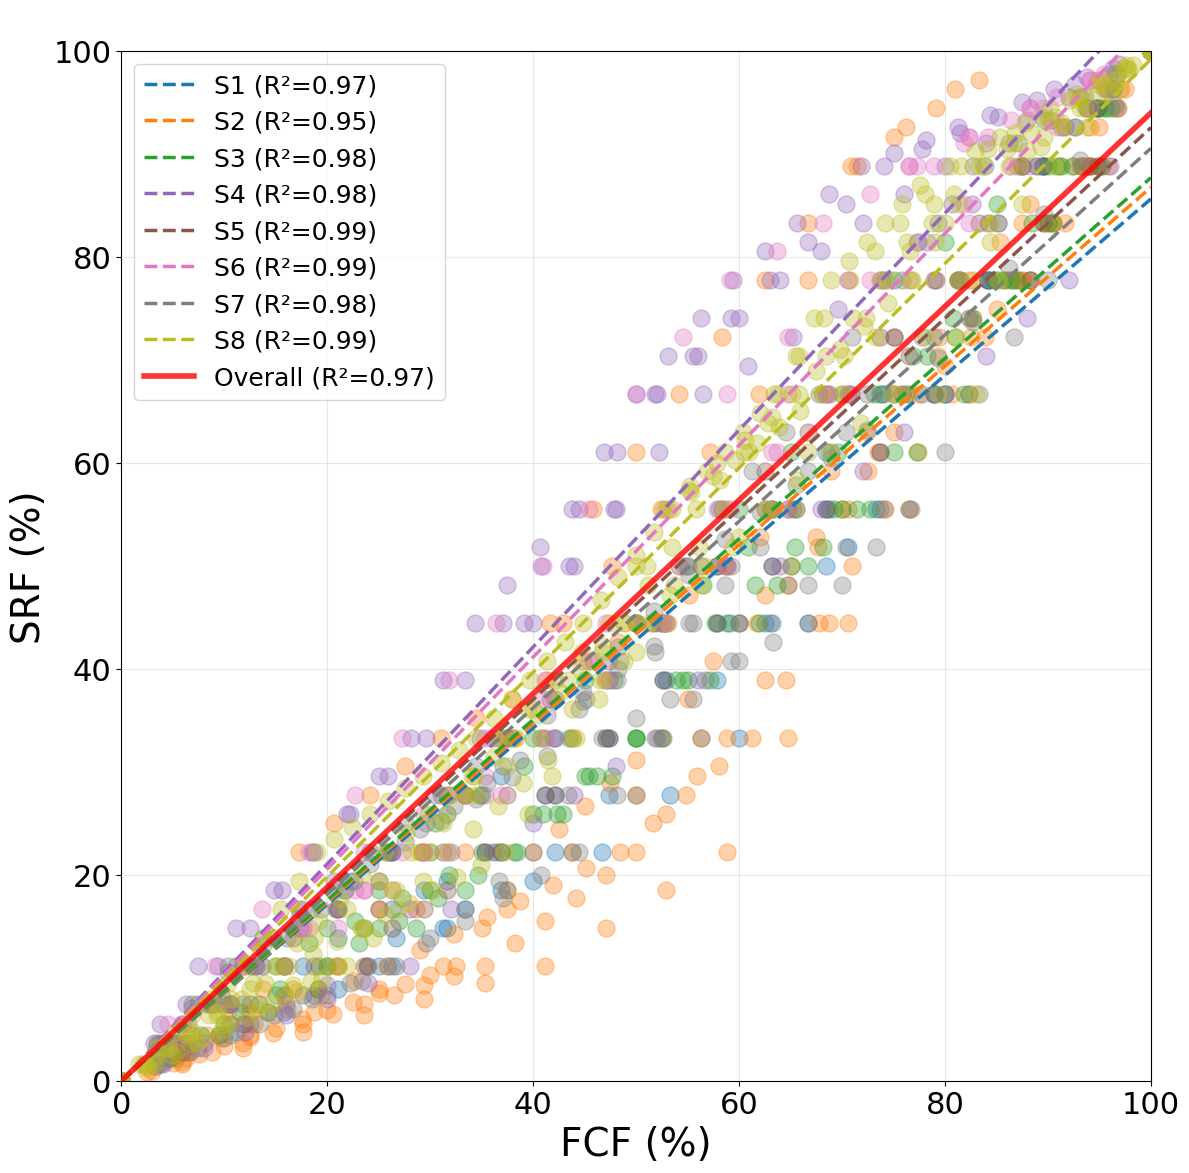

✅ Created single figure successfully!
📊 Processed 8 subjects: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']
📈 Overall fit: Slope=0.940, R²=0.973


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.optimize import curve_fit

# Set up matplotlib
plt.style.use('default')

# Update this path to your Excel file
EXCEL_PATH = r"C:\Users\ezior\Downloads\SRF.xlsx"

# Load data
data = pd.read_excel(EXCEL_PATH)
print(f"Loaded data shape: {data.shape}")

# Filter out 'Circ' columns (include_circ=False)
filtered_columns = [col for col in data.columns if 'Circ' not in str(col)]
data = data[filtered_columns]

# Enhanced label smoothing function
def apply_label_smoothing(values):
    """Apply enhanced label smoothing for repeated values"""
    smoothed = values.copy().astype(float)
    i = 0
    while i < len(values):
        current_val = values[i]
        # Count consecutive repeats
        count = 1
        j = i + 1
        while j < len(values) and values[j] == current_val:
            count += 1
            j += 1
        
        # Apply smoothing if repeated
        if count > 1:
            step = 1.0 / count
            for k in range(count):
                smoothed[i + k] = float(current_val) + (k * step)
        i = j
    return smoothed

# Prepare plotting data
plot_data_list = []

for col in data.columns:
    col_str = str(col)
    
    # Extract subject info
    subject_match = re.search(r'S\d+', col_str)
    subject = subject_match.group() if subject_match else 'Unknown'
    
    # Get SRF values (remove NaN)
    srf_values = data[col].dropna().values
    if len(srf_values) == 0:
        continue
    
    # Apply label smoothing
    srf_values = apply_label_smoothing(srf_values)
    
    # Create completion percentage
    completion_pct = np.linspace(0, 100, len(srf_values))
    
    # Force start from zero
    srf_offset = srf_values[0]
    srf_values = srf_values - srf_offset
    comp_offset = completion_pct[0]
    completion_pct = completion_pct - comp_offset
    if len(completion_pct) > 1:
        max_comp = completion_pct[-1]
        if max_comp > 0:
            completion_pct = (completion_pct / max_comp) * 100
    
    # Normalize to 0-100 percent
    if srf_values.max() != srf_values.min():
        srf_values = ((srf_values - srf_values.min()) / 
                     (srf_values.max() - srf_values.min())) * 100
    
    # Store data
    for i in range(len(srf_values)):
        plot_data_list.append({
            'completion_percentage': completion_pct[i],
            'srf_value': srf_values[i],
            'subject': subject,
            'column_name': col_str
        })

# Convert to DataFrame
plot_data = pd.DataFrame(plot_data_list)
print(f"Prepared {len(plot_data)} data points")

# Get unique subjects and create colors (excluding red)
unique_subjects = sorted(plot_data['subject'].unique())
# Get tab10 colors but skip red (index 3)
all_colors = plt.cm.tab10(np.arange(10))
non_red_colors = [all_colors[i] for i in range(10) if i != 3]  # Skip index 3 (red)
# Repeat colors if we have more subjects than colors
while len(non_red_colors) < len(unique_subjects):
    non_red_colors.extend(non_red_colors)
color_dict = dict(zip(unique_subjects, non_red_colors[:len(unique_subjects)]))

# Linear fitting function (through origin)
def linear_fit(x, slope):
    return slope * x

# Calculate overall fit for overlay
x_all = plot_data['completion_percentage'].values
y_all = plot_data['srf_value'].values

# Remove NaN values
mask = ~(np.isnan(x_all) | np.isnan(y_all))
x_all = x_all[mask]
y_all = y_all[mask]

# Calculate overall slope and R²
overall_slope = 0
overall_r2 = 0
if len(x_all) > 1 and np.sum(x_all**2) != 0:
    overall_slope = np.sum(x_all * y_all) / np.sum(x_all**2)
    y_pred = overall_slope * x_all
    ss_res = np.sum((y_all - y_pred)**2)
    ss_tot = np.sum(y_all**2)
    overall_r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

# === MAIN FIGURE: Individual Fits + Overall Overlay ===
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# Fit individual subjects
for subject in unique_subjects:
    subject_data = plot_data[plot_data['subject'] == subject]
    
    if len(subject_data) > 1:
        x_subj = subject_data['completion_percentage'].values
        y_subj = subject_data['srf_value'].values
        
        # Remove NaN values
        mask = ~(np.isnan(x_subj) | np.isnan(y_subj))
        x_subj = x_subj[mask]
        y_subj = y_subj[mask]
        
        if len(x_subj) > 1:
            color = color_dict[subject]
            
            # Plot subject data
            ax.scatter(x_subj, y_subj, color=color, alpha=0.35, s=150)
            
            # Fit linear curve for this subject
            if np.sum(x_subj**2) != 0:
                subj_slope = np.sum(x_subj * y_subj) / np.sum(x_subj**2)
                
                # Calculate R² for subject
                y_pred_subj = subj_slope * x_subj
                ss_res_subj = np.sum((y_subj - y_pred_subj)**2)
                ss_tot_subj = np.sum(y_subj**2)
                r2_subj = 1 - (ss_res_subj / ss_tot_subj) if ss_tot_subj != 0 else 0
                
                # Plot subject fit
                x_smooth_subj = np.linspace(0, x_subj.max(), 50)
                y_smooth_subj = subj_slope * x_smooth_subj
                
                ax.plot(x_smooth_subj, y_smooth_subj, color=color, 
                       linewidth=2.5, linestyle='--',
                       label=f'{subject} (R²={r2_subj:.2f})')

# Overlay overall fit
if overall_slope > 0:
    x_smooth_overall = np.linspace(0, 100, 100)
    y_smooth_overall = overall_slope * x_smooth_overall
    ax.plot(x_smooth_overall, y_smooth_overall, color='red', 
           linewidth=4.0, label=f'Overall (R²={overall_r2:.2f})', 
           alpha=0.8, zorder=10)

ax.set_title(" ", fontsize=30, fontweight='bold')
ax.set_xlabel("FCF (%)", fontsize=28)
ax.set_ylabel("SRF (%)", fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=18, loc='upper left')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Set custom ticks
x_ticks = np.arange(0, 101, 20)
y_ticks = np.arange(0, 101, 20)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_box_aspect(1)

# Apply tight layout
fig.tight_layout()

# Show plot
plt.show()

print(f"✅ Created single figure successfully!")
print(f"📊 Processed {len(unique_subjects)} subjects: {unique_subjects}")
print(f"📈 Overall fit: Slope={overall_slope:.3f}, R²={overall_r2:.3f}")

In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import re
import warnings
warnings.filterwarnings('ignore')


class SimpleDatasetManager:
    """Simple dataset manager for loading and combining CSV files"""
    
    def __init__(self, data_directory: str = None):
        self.data_directory = data_directory
        self.data = None
        self.subjects = []
        self.available_features = []
        
    def load_all_data(self, pattern: str = "*.csv", target_column: str = 'completion_percentage'):
        """Load and combine all CSV files from directory"""
        if not self.data_directory:
            raise ValueError("Data directory not specified")
        
        csv_files = glob.glob(str(Path(self.data_directory) / pattern))
        if not csv_files:
            print(f"No files found matching pattern '{pattern}'")
            return
        
        # Group files by subject
        subject_files = {}
        for file_path in csv_files:
            file_name = Path(file_path).stem
            subject_match = re.search(r'S(\d+)', file_name, re.IGNORECASE)
            
            if subject_match:
                subject_num = int(subject_match.group(1))
                if subject_num not in subject_files:
                    subject_files[subject_num] = []
                subject_files[subject_num].append({
                    'path': file_path,
                    'name': file_name,
                    'type': 'HD' if 'HD' in file_name.upper() else 'MD' if 'MD' in file_name.upper() else 'Unknown'
                })
        
        # Load and combine data
        all_dataframes = []
        for subject_num, files in sorted(subject_files.items()):
            subject_dataframes = []
            
            for file_info in files:
                try:
                    df = pd.read_csv(file_info['path'])
                    
                    if 'subject_id' in df.columns:
                        df['subject_id'] = subject_num
                    else:
                        df['subject_id'] = subject_num
                    
                    # Create unique trial indices
                    trial_match = re.search(r'Trial_(\d+)', file_info['name'], re.IGNORECASE)
                    if trial_match:
                        original_trial = int(trial_match.group(1))
                        file_type = file_info['type']
                        
                        if file_type == 'MD':
                            unique_trial_index = original_trial + 100
                        else:
                            unique_trial_index = original_trial
                        
                        df['trial_index'] = unique_trial_index
                        df['original_trial_number'] = original_trial
                    
                    df['file_type'] = file_info['type']
                    df['source_file'] = file_info['name']
                    subject_dataframes.append(df)
                    
                except Exception as e:
                    print(f"Failed to load {file_info['name']}: {e}")
            
            if subject_dataframes:
                subject_combined = pd.concat(subject_dataframes, ignore_index=True)
                all_dataframes.append(subject_combined)
        
        if not all_dataframes:
            print("No data loaded successfully")
            return
        
        self.data = pd.concat(all_dataframes, ignore_index=True)
        
        # Check required columns
        required_cols = ['subject_id', 'trial_index', 'cycle_index']
        missing_cols = [col for col in required_cols if col not in self.data.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return
        
        if target_column not in self.data.columns:
            print(f"Target column '{target_column}' not found")
            return
        
        self._update_metadata()
        
    def _update_metadata(self):
        """Update metadata about the dataset"""
        if self.data is None:
            return
        
        self.subjects = sorted(self.data['subject_id'].unique())
        
        metadata_cols = ['subject_id', 'trial_index', 'cycle_index', 'completion_percentage', 
                        'subjective_fatigue', 'motion_type', 'damping_level', 'dataset_source',
                        'file_type', 'source_file']
        self.available_features = [col for col in self.data.columns if col not in metadata_cols]
    
    def get_data_for_subjects(self, subjects=None):
        """Get data for specific subjects"""
        if self.data is None:
            print("No data loaded")
            return pd.DataFrame()
        
        if subjects is None:
            return self.data.copy()
        
        if not isinstance(subjects, list):
            subjects = [subjects]
        
        return self.data[self.data['subject_id'].isin(subjects)]
    
    def get_feature_names(self, feature_type='all'):
        """Get list of available feature names"""
        if not self.available_features:
            return []
        
        features = self.available_features.copy()
        
        if feature_type == 'all':
            return features
        elif feature_type == 'original':
            return [f for f in features if not f.endswith('_pct_change')]
        elif feature_type == 'pct_change':
            return [f for f in features if f.endswith('_pct_change')]
        elif feature_type == 'rms':
            return [f for f in features if 'rms' in f.lower()]
        elif feature_type == 'channel':
            return [f for f in features if f.startswith('ch')]
        else:
            return features
    
    
    def summary(self):
        """Print basic dataset summary"""
        if self.data is None:
            print("No data loaded")
            return
        
        print(f"Dataset: {self.data.shape}")
        print(f"Subjects: {self.subjects}")




# Example usage
if __name__ == "__main__":
    manager = SimpleDatasetManager(r"C:\Users\ezior\Downloads\EMG_ML_Features")
    manager.load_all_data("*.csv")
    manager.summary()


Dataset: (1360, 42)
Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9]


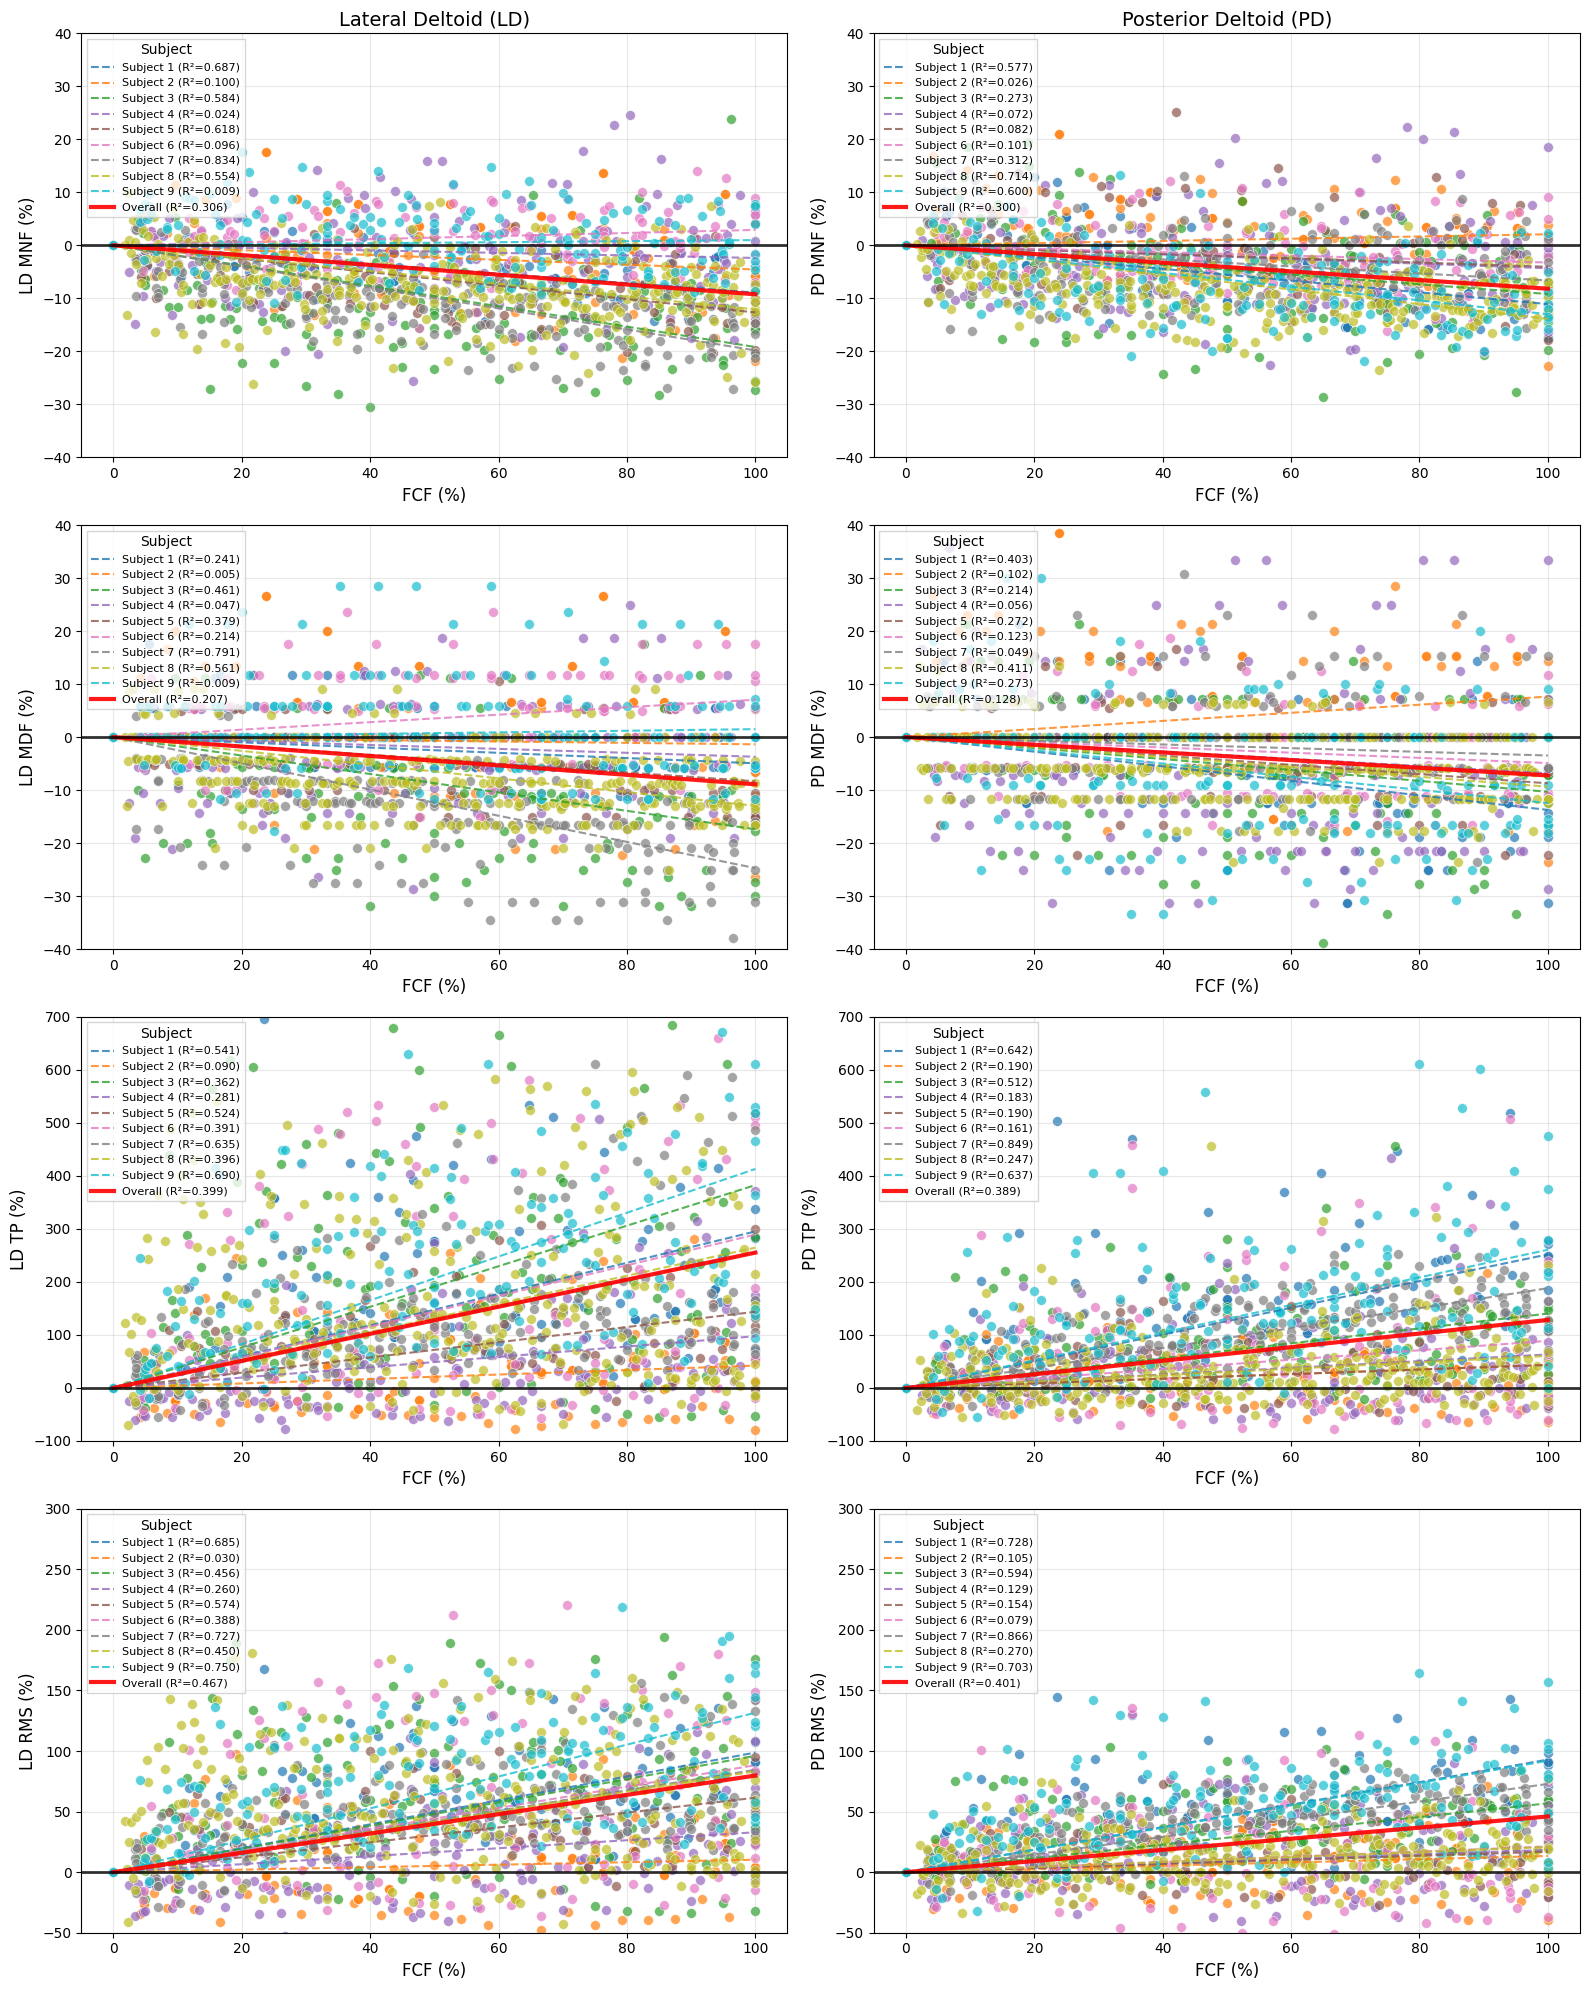

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from typing import List, Dict, Tuple

def plot_features_grid(data_manager, plot_configs: List[Dict], 
                      subjects=None,
                      x_axis: str = 'completion_percentage',
                      xlabel: str = 'FCF (%)',
                      figsize: Tuple[int, int] = (16, 20),
                      n_rows: int = 4, n_cols: int = 2,
                      save_path: str = None,
                      show_plot: bool = True,
                      suptitle: str = None):
    """Simple grid plot of EMG features with original styling."""
    
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return
    
    # Setup colors (excluding red for subjects, original tab10 style)
    subjects = data['subject_id'].unique()
    color_dict = _create_color_dict_no_red(subjects, 'tab10')
    
    # Default styles from original
    zero_line_style = {'color': 'black', 'linewidth': 2, 'linestyle': '-', 'alpha': 0.8}
    fit_line_style = {'color': 'red', 'linewidth': 3, 'linestyle': '-', 'alpha': 0.9}
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for i, config in enumerate(plot_configs[:len(axes)]):
        if 'feature' not in config:
            continue
            
        feature = config['feature']
        ax = axes[i]
        
        # Check feature availability
        available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
        if feature not in available_features:
            print(f"Invalid feature '{feature}' for subplot {i+1}")
            ax.text(0.5, 0.5, f"Invalid feature:\n{feature}", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"Subplot {i+1}: ERROR")
            continue
        
        all_x_clean, all_y_clean = [], []
        
        # Plot each subject
        for subject in subjects:
            subject_data = data[data['subject_id'] == subject].sort_values(x_axis)
            x_vals = subject_data[x_axis].values
            y_vals = subject_data[feature].values
            
            # Remove NaN
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_vals, y_vals = x_vals[mask], y_vals[mask]
            
            if len(x_vals) == 0:
                continue
            
            # Apply outlier rejection if specified in config
            if config.get('outlier_rejection', False) and len(x_vals) > 3:
                x_vals, y_vals, _ = _remove_outliers(x_vals, y_vals, config.get('outlier_z_threshold', 3.0))
                if len(x_vals) == 0:
                    continue
                    
            all_x_clean.extend(x_vals)
            all_y_clean.extend(y_vals)
            
            color = color_dict[subject]
            
            # Scatter plot
            ax.scatter(x_vals, y_vals, color=color, alpha=0.7, s=50, 
                      edgecolors='white', linewidth=0.5)
            
            # Individual trend line (dashed) - force zero intercept
            if len(x_vals) > 1:
                slope = np.sum(x_vals * y_vals) / np.sum(x_vals**2)
                y_pred = slope * x_vals
                ss_res = np.sum((y_vals - y_pred)**2)
                ss_tot = np.sum(y_vals**2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
                
                ax.plot(x_vals, y_pred, color=color, linestyle='--', linewidth=1.5, alpha=0.8,
                       label=f'Subject {subject} (R²={r2:.3f})')
        
        # Overall trend line (solid red)
        if len(all_x_clean) > 1:
            all_x, all_y = np.array(all_x_clean), np.array(all_y_clean)
            slope = np.sum(all_x * all_y) / np.sum(all_x**2)
            x_smooth = np.linspace(all_x.min(), all_x.max(), 100)
            y_smooth = slope * x_smooth
            
            y_pred = slope * all_x
            ss_res = np.sum((all_y - y_pred)**2)
            ss_tot = np.sum(all_y**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            ax.plot(x_smooth, y_smooth, color='red', linewidth=3, linestyle='-', alpha=0.9,
                   label=f'Overall (R²={r2:.3f})')
        
        # Zero line
        ax.axhline(y=0, color=zero_line_style['color'], linewidth=zero_line_style['linewidth'], 
                  linestyle=zero_line_style['linestyle'], alpha=zero_line_style['alpha'])
        
        # Formatting with original font sizes
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(config.get('ylabel', feature.replace('_', ' ').title()), fontsize=12)
        
        # Title only on first row
        if i < n_cols:
            ax.set_title(config.get('title', feature.replace('_', ' ').title()), fontsize=14)
        
        # Apply custom y-axis settings
        if 'ylim' in config:
            ax.set_ylim(config['ylim'])
        if 'yscale' in config:
            ax.set_yscale(config['yscale'])
            
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(title='Subject', loc='upper left', fontsize=8, framealpha=0.8,
                 fancybox=False, shadow=False)
    
    # Hide unused subplots
    for i in range(len(plot_configs), len(axes)):
        axes[i].set_visible(False)
    
    # Add overall title
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    if suptitle:
        plt.subplots_adjust(top=0.95)
    
    # Save plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig, axes

def _remove_outliers(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask], outlier_mask

def _create_color_dict_no_red(unique_groups, color_palette):
    """Create color dictionary excluding red colors (reserved for overall trend)."""
    if color_palette == 'tab10':
        # Get tab10 colors but exclude red (index 3)
        all_colors = plt.cm.tab10(np.arange(10))
        colors = [color for i, color in enumerate(all_colors) if i != 3]  # Remove red
    elif color_palette == 'Set1':
        # Get Set1 colors but exclude red-ish colors
        all_colors = plt.cm.Set1(np.arange(9))
        colors = [color for i, color in enumerate(all_colors) if i not in [0, 5]]  # Remove red and pink
    else:
        # For other palettes, try to exclude red-ish colors
        all_colors = plt.cm.get_cmap(color_palette)(np.linspace(0, 1, len(unique_groups) + 3))
        colors = []
        for color in all_colors:
            # Skip colors that are too red (high red, low green and blue)
            if not (color[0] > 0.7 and color[1] < 0.5 and color[2] < 0.5):
                colors.append(color)
    
    # Ensure we have enough colors
    while len(colors) < len(unique_groups):
        colors.extend(colors)
    
    return dict(zip(unique_groups, colors[:len(unique_groups)]))

# Example usage
PLOT_CONFIGS = [
    {'feature': 'ch2_mean_power_freq_max_pct_change', 'title': 'Lateral Deltoid (LD)', 
     'ylim': (-40, 40), 'ylabel': 'LD MNF (%)'},
    {'feature': 'ch1_mean_power_freq_max_pct_change', 'title': 'Posterior Deltoid (PD)', 
     'ylim': (-40, 40), 'ylabel': 'PD MNF (%)'},
    {'feature': 'ch2_median_power_freq_max_pct_change', 'title': 'LD Median Power Frequency', 
     'ylim': (-40, 40), 'ylabel': 'LD MDF (%)'},
    {'feature': 'ch1_median_power_freq_max_pct_change', 'title': 'PD Median Power Frequency', 
     'ylim': (-40, 40), 'ylabel': 'PD MDF (%)'},
    {'feature': 'ch2_total_power_max_pct_change', 'ylim': (-100, 700), 'ylabel': 'LD TP (%)'},
    {'feature': 'ch1_total_power_max_pct_change', 'ylim': (-100, 700), 'ylabel': 'PD TP (%)'},
    {'feature': 'ch2_rms_max_pct_change', 'ylim': (-50, 300), 'ylabel': 'LD RMS (%)', 'outlier_rejection': True},
    {'feature': 'ch1_rms_max_pct_change', 'ylim': (-50, 300), 'ylabel': 'PD RMS (%)', 'outlier_rejection': True},
]

# Usage:
fig, axes = plot_features_grid(manager, PLOT_CONFIGS)